In [1]:
import uproot
import matplotlib
import matplotlib.pyplot as plt
import awkward as ak
import hist
import numpy as np
from event_display import gdml_read_ecal_info
import os
import pandas as pd
import matplotlib.patches as mpatches
from scipy.stats import crystalball, norm

%matplotlib inline
matplotlib.rc("figure", dpi=200)

dir_path = os.path.dirname(os.path.realpath("__file__"))
print(f"Believed path is: {dir_path}")

Believed path is: /home/romanov/eic/kak-bog-cherepahu/analysis


In [2]:
import pandas as pd

all_vals_df = pd.read_feather("/mnt/work/data/epi/2022-12-01_cherepaha_PWO-CRYTUR_13x13_20x20x200mm_1-6GeV_e-pi-_10kev-each.feather")
all_vals_df["e_div_p"] = all_vals_df.de_sum/(all_vals_df.p*1000)
all_vals_df.head()

,p,prt_name,de_sum,towers,e_div_p
0,1.0,e-,989.973961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.989974
1,1.0,e-,989.192128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.989192
2,1.0,e-,988.610162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.04927854...",0.988610
3,1.0,e-,988.306117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.988306
4,1.0,e-,980.594755,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1620036960593...",0.980595


In [15]:
def make_2sigma_separation(e_df, pi_df):
    # Fit with crystalball and gauss
    cb_beta, cb_m, cb_loc, cb_scale = crystalball.fit(e_df.e_div_p, loc=0.6)
    norm_loc, norm_scale = norm.fit(e_df.e_div_p)
    print(cb_beta, cb_m, cb_loc, cb_scale)
    print(norm_loc, norm_scale)

    # where we separate
    norm_sigmas = 2
    separ_x = cb_loc - norm_scale*norm_sigmas
    n_pi_above_num = np.size(pi_df.query(f"e_div_p > {separ_x}").e_div_p)
    n_e_below_num = np.size(e_df.query(f"e_div_p <= {separ_x}").e_div_p)
    n_e_above_num = np.size(e_df.query(f"e_div_p > {separ_x}").e_div_p)

    n_pi_above = n_pi_above_num / np.size(pi_df.e_div_p)
    n_e_below = n_e_below_num / np.size(e_df.e_div_p)
    n_e_above = n_e_above_num / np.size(e_df.e_div_p)

    print(separ_x, n_pi_above, n_e_below, n_e_above, np.size(e_df.e_div_p))

    # We can set the number of bins with the *bins* keyword argument.
    fig, axs = plt.subplots()    
    axs.hist(e_df.e_div_p, bins=50, alpha = 0.5, edgecolor='blue', linewidth=0.3, range=(0, 1), density=True, label="$e^{-}$")
    axs.hist(pi_df.e_div_p, bins=50, alpha = 0.5, edgecolor='red', linewidth=0.3, range=(0, 1), density=True, label="$\pi^{-}$")
    axs.axvline(x=separ_x, color='red', linestyle='--', linewidth=0.8, label=f"peak-{norm_sigmas}$\sigma$ = {separ_x:.2f}")
    axs.plot([], [], ' ', label="$\epsilon_{e^{-}}$ = " + f"{n_e_above*100:.2f}%")
    axs.plot([], [], ' ', label="$\epsilon_{\pi^{-}}$ = " + f"{n_pi_above*100:.2f}%")
    axs.legend(loc='best')
    axs.set_title(f"E/P PbWO4 2x2x20cm <E> = {e_df.p.mean():.1f} GeV")
    # txt = ax.text(0.5, 0.5, f"{separ_x}\n {n_pi_above}, {n_e_below}, {n_e_above}")
    # txt.set_clip_on(False)
    # handles, labels = plt.get_legend_handles_labels()
    # handles.append(mpatches.Patch(color='none', label=extraString))
    # plt.legend(handles=handles)
    # # txt.set_clip_on(False)  # this will turn clipping off (always visible)
    # plt.plot()

def df_make_separation(df, e_center, range=1):
    e_min = e_center - 0.5*range
    e_max = e_center + 0.5*range
    e_filtered_df = all_vals_df.query(f"({e_min} < p < {e_max}) and prt_name=='e-'")
    pi_filtered_df = all_vals_df.query(f"({e_min} < p < {e_max}) and prt_name=='pi-'")

    make_2sigma_separation(e_filtered_df, pi_filtered_df)


0.2684625202947849 7.786180957531547 0.9940449519979666 0.002414001488332116
0.9850102216728411 0.016968172362616253
0.9601086072727341 0.0094 0.0396 0.9604 10000


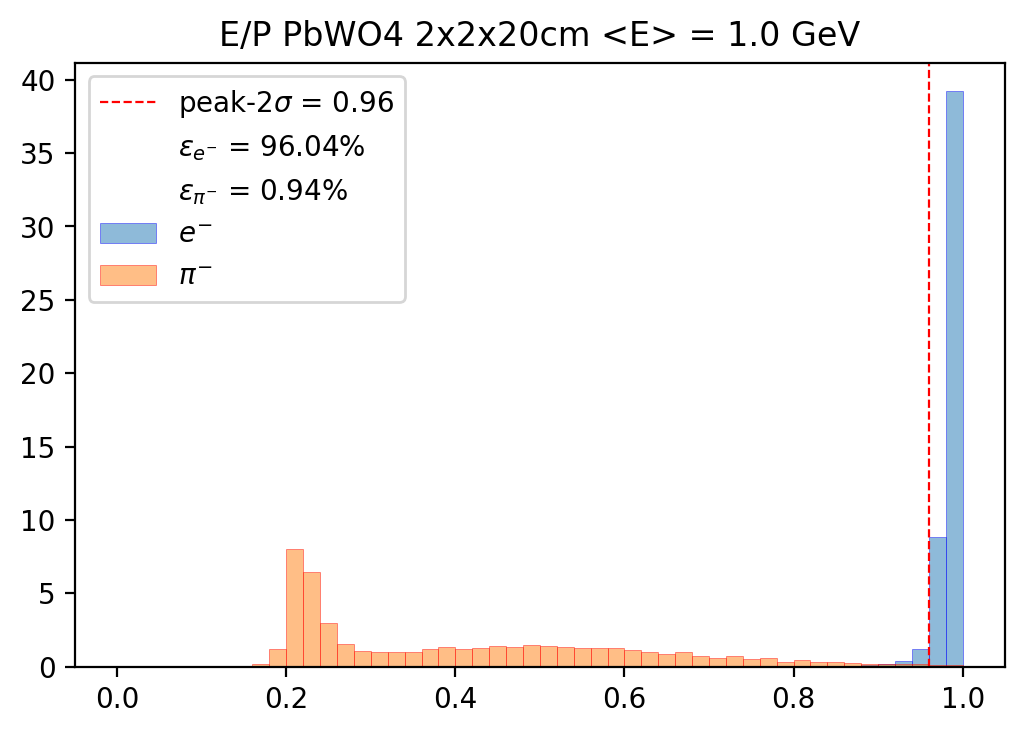

In [16]:
df_make_separation(all_vals_df, 1)


0.6328818461811341 5.161018796783733 0.9896905191524044 0.0037287507677265784
0.984869927655225 0.013973974891345685
0.961742569369713 0.0007 0.0329 0.9671 10000


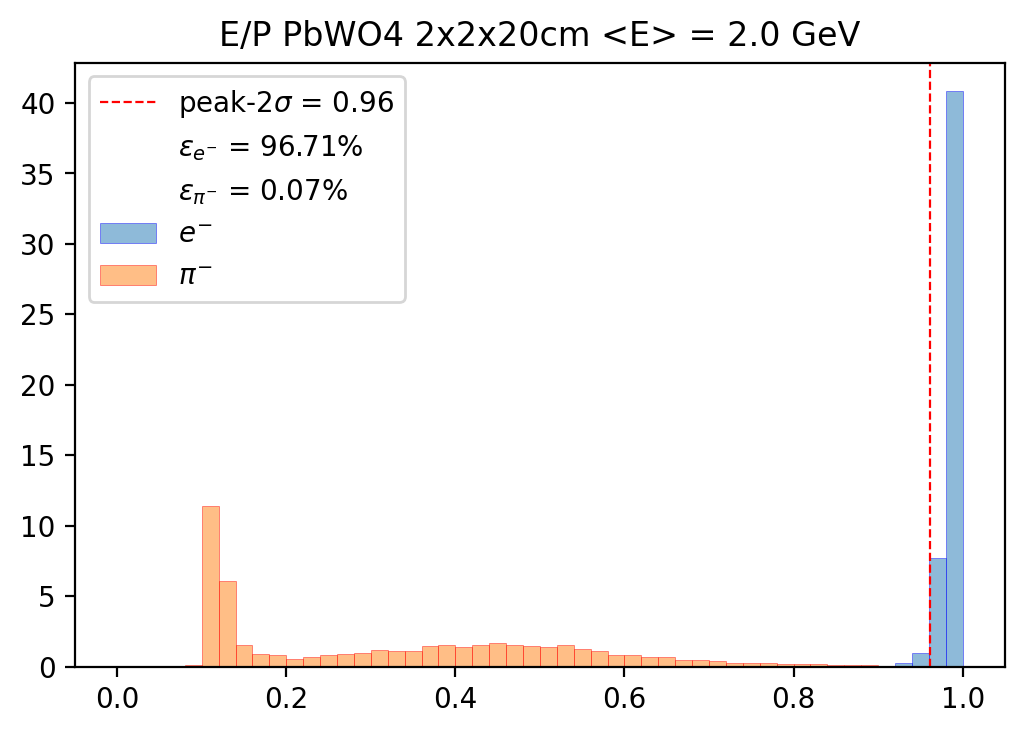

In [17]:
df_make_separation(all_vals_df, 2)

0.6655217865215175 4.97958836605217 0.9885206560063329 0.00367900872607022
0.9840347440356371 0.014426942429143245
0.9596667711480464 0.0009 0.0273 0.9727 10000


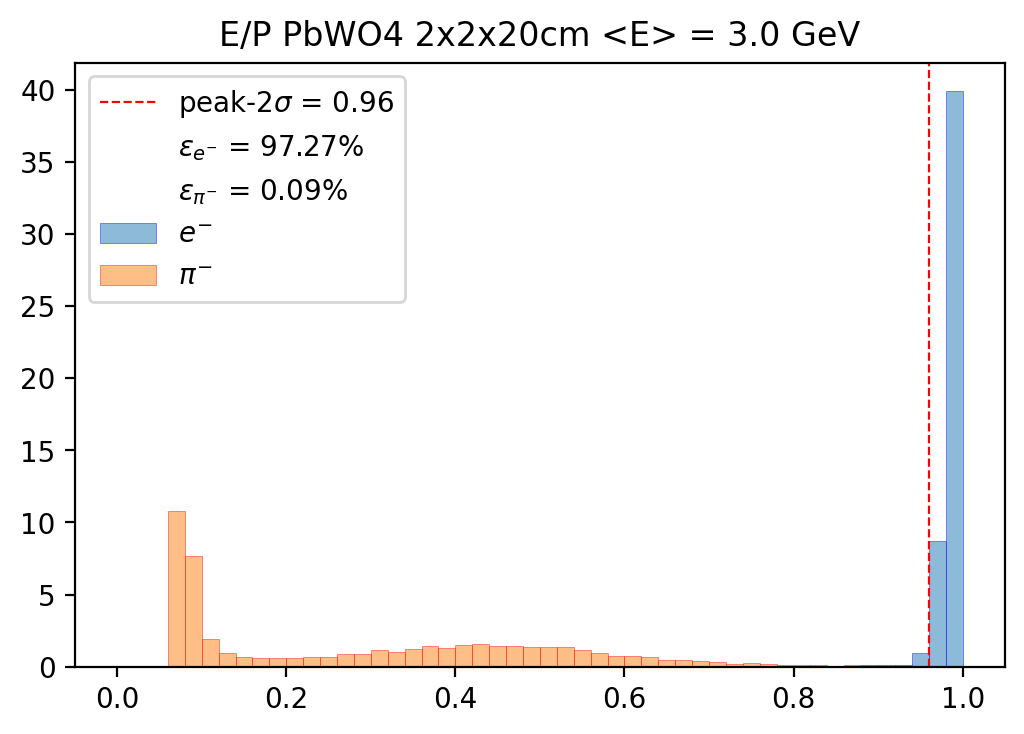

In [18]:
df_make_separation(all_vals_df, 3)

0.6873553356302282 5.204701678870974 0.9875890908500514 0.0035926165482618056
0.9833192494923686 0.01748123432257548
0.9526266222049005 0.0017 0.0168 0.9832 10000


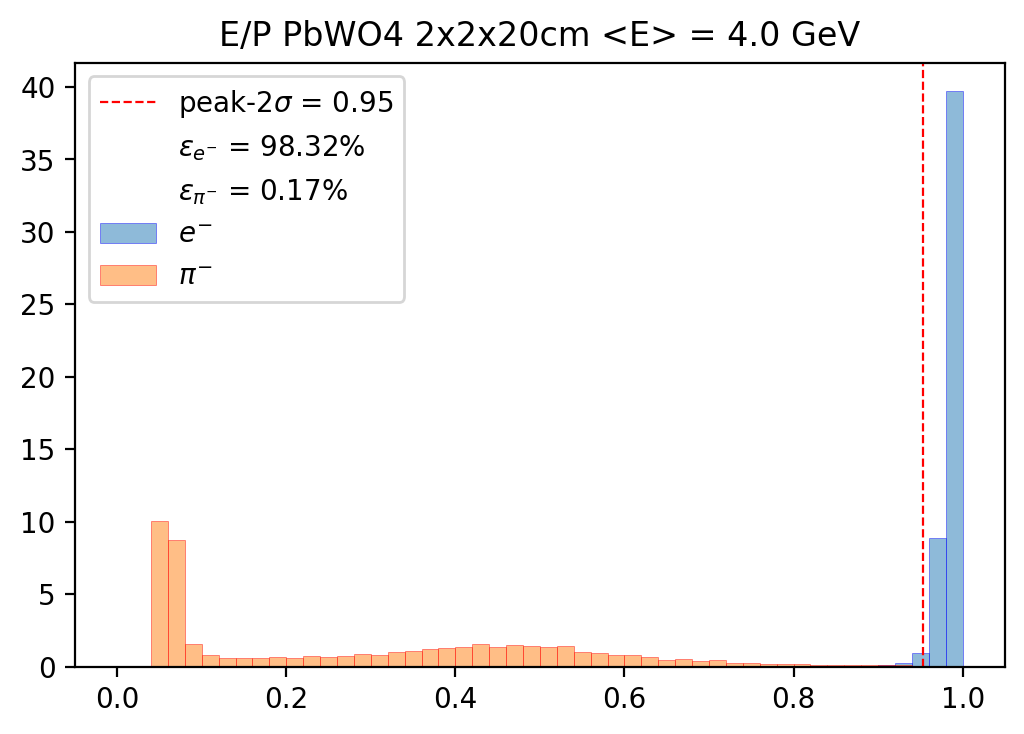

In [19]:
df_make_separation(all_vals_df, 4)

0.6849576608740621 5.154120220174518 0.9870597736868421 0.0034641573757147903
0.9831961740360512 0.012025362599668975
0.9630090484875041 0.0015 0.0306 0.9694 10000


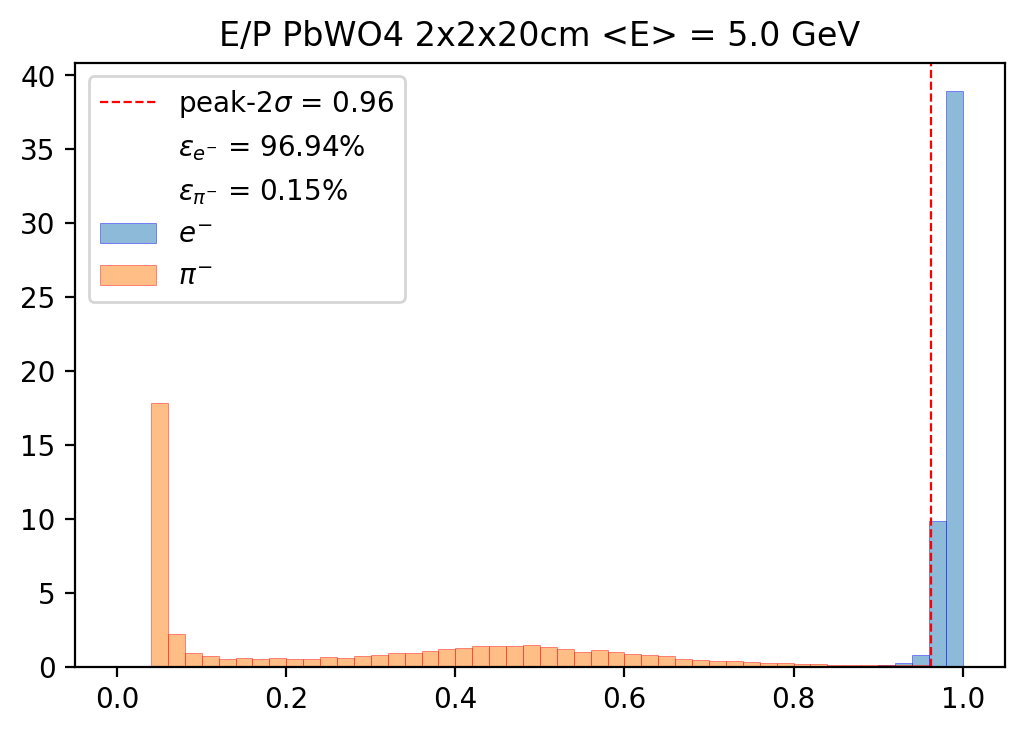

In [21]:
df_make_separation(all_vals_df, 5)